In [1]:
import torch
from torch import nn 
import numpy as np
import gym
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import json

C:\Users\boh-b\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\tensorboard\__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [2]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.device = torch.device('cuda')
        self.state_dim = state_dim
        self.action_n = action_n
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 32), 
            nn.ReLU(), 
            nn.Linear(32, 32), 
            nn.ReLU(), 
            nn.Linear(32, self.action_n)
        )
        #self.network.to(self.device)
        
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.012)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, _input):
        #_input = _input.to(self.device)
        return self.network(_input)
    
    def get_action(self, state, exploration=0):
        state = torch.FloatTensor(state)
        #logits = self.forward(state).to('cpu')
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        p=(1-exploration)*action_prob+exploration*np.ones(self.action_n)/self.action_n
        if(exploration < 0):
            action = np.argmax(action_prob)
        else:
            action = np.random.choice(self.action_n, p=p/p.sum())
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        #elite_states = elite_states.to(self.device)
        elite_actions = torch.LongTensor(np.array(elite_actions))
        #elite_actions = elite_actions.to(self.device)
        self.optimizer.zero_grad()
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()

In [3]:
def get_trajectory(env, agent, trajectory_len, exploration=0, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    for i in range(trajectory_len):
        with torch.no_grad():
            action = agent.get_action(state, exploration)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        if visualize:
            env.render()
        
        if(i != trajectory_len-1):
            trajectory['states'].append(state)
    
    if visualize:
        print(i,trajectory['total_reward'])  
    return trajectory

In [4]:
def get_elite_trajectories(trajectories, q_param, solved_traj):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    new_solved = [trajectory for trajectory in trajectories if trajectory['total_reward'] >= 200]
    if(len(new_solved)):
        solved_traj.extend(new_solved)
        pass
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]



In [5]:
env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4
writer = SummaryWriter()
learnin_hist = {'mean_reward': [], 'exploration': [], 'validation': []}

agent = CEM(state_dim, action_n)
#agent = CEM(state_dim, action_n)
#agent.load_state_dict(torch.load('luna3232.model'))

In [6]:
trajectory_len = 400
q_param = 0.8
exploration = 0.9
e_rate = 0.993
solved_traj = []

In [32]:
episode_n = 2000
trajectory_n = 20

for episode in range(1221,episode_n):
    trajectories = [get_trajectory(env, agent, trajectory_len, exploration+0.002) for _ in range(trajectory_n)]
    exploration *= e_rate
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    writer.add_scalar('mtr', mean_total_reward, episode)
    print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    elite_trajectories = get_elite_trajectories(trajectories, q_param, solved_traj)
    print('solved =',len(solved_traj),' elite len =',len(elite_trajectories))
    learnin_hist['exploration'].append([episode,mean_total_reward])
    learnin_hist['mean_reward'].append([episode,mean_total_reward])
    if episode%10==0:
        trajectories = [get_trajectory(env, agent, trajectory_len, -1) for _ in range(trajectory_n*3)]
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        if(mean_total_reward>260):
            break
        learnin_hist['validation'].append([episode,mean_total_reward])
        print('validation =', mean_total_reward)
    if len(elite_trajectories) > 0:
        if(len(solved_traj)>0):
            elite_trajectories.append(solved_traj[np.random.randint(len(solved_traj))])
            agent.update_policy(elite_trajectories)
        else:
            agent.update_policy(elite_trajectories)

C:\Users\boh-b\AppData\Local\Temp\ipykernel_11524\2924297689.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


episode: 1221, mean_total_reward = 147.57909852113758
solved = 288  elite len = 4
episode: 1222, mean_total_reward = 144.99118427094598
solved = 290  elite len = 4
episode: 1223, mean_total_reward = 127.22729444903307
solved = 290  elite len = 4
episode: 1224, mean_total_reward = 129.07191801119217
solved = 291  elite len = 4
episode: 1225, mean_total_reward = 109.85066395393986
solved = 292  elite len = 4
episode: 1226, mean_total_reward = 128.01790606164644
solved = 292  elite len = 4
episode: 1227, mean_total_reward = 112.10921295537798
solved = 292  elite len = 4
episode: 1228, mean_total_reward = 131.61850607145834
solved = 293  elite len = 4
episode: 1229, mean_total_reward = 121.731738147674
solved = 294  elite len = 4
episode: 1230, mean_total_reward = 147.68782580652783
solved = 295  elite len = 4
validation = 138.7384434258217
episode: 1231, mean_total_reward = 143.66093981148154
solved = 295  elite len = 4
episode: 1232, mean_total_reward = 142.40485703414805
solved = 295  e

In [44]:
get_trajectory(env, agent, 4000, exploration=-1,visualize=True)
print()

C:\Users\boh-b\AppData\Local\Temp\ipykernel_11524\2924297689.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


261 232.8996827159056



In [68]:
torch.save(agent.state_dict(), 'luna3232_best.model')

In [59]:
model = CEM(state_dim, action_n)
model.load_state_dict(torch.load('luna3232_best.model'))
model.eval()

CEM(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=None)
  (loss): CrossEntropyLoss()
)

In [33]:
trajectories = [get_trajectory(env, agent, 400,-1) for _ in range(100)]
mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
mean_total_reward

C:\Users\boh-b\AppData\Local\Temp\ipykernel_11524\2924297689.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


267.44947532570393

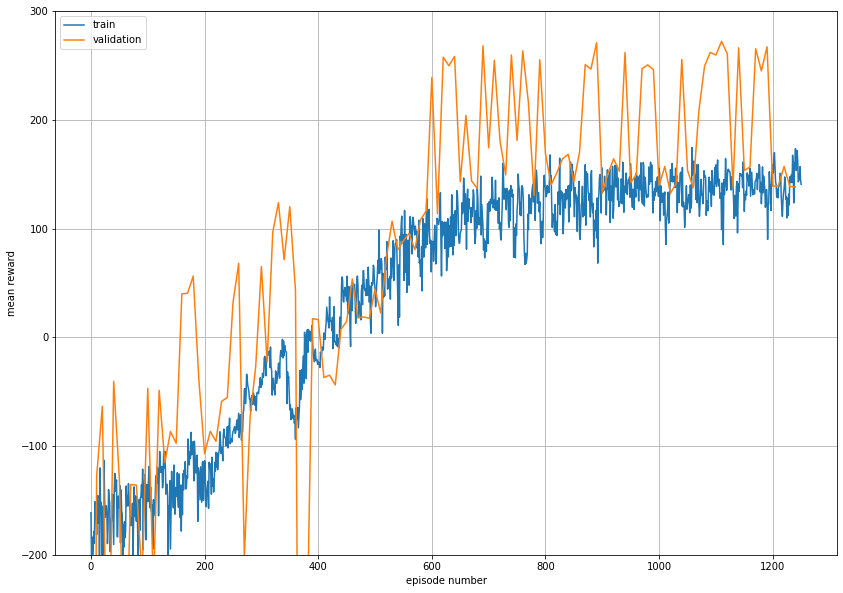

In [67]:
plt.figure(figsize=[14,10])
plt.plot(np.array(learnin_hist['mean_reward'])[:,0],np.array(learnin_hist['mean_reward'])[:,1],label='train')
plt.plot(np.array(learnin_hist['validation'])[:,0],np.array(learnin_hist['validation'])[:,1],label='validation')
plt.grid(True)
plt.ylim([-200,300])
plt.xlabel('episode number')
plt.ylabel('mean reward')
plt.legend()
plt.savefig('train.png',dpi=300,bbox_inches='tight',facecolor='white')